In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import display
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Data Repository
from ucimlrepo import fetch_ucirepo 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets

# Geommetric Analysis of Tumorous Cells in Breast Tissue

## Explanation
- Cell 2: Data Exploration and Comparison of Relevant Texture Features
- Cell 3: Entropy and Information Gain
- Cell 4: Decision Tree

## Summary:
While it is very close to determine whether a tumor cell is benign or malignant without taking any of its features into consideration due to high data entropy (0.9526), the analysis of their textures do not really add any new information that helps us make our guess any better.

The information gain for texture is 0.1844, for smoothness it is 0.1137, for symmetry 0.0929 and for fractal dimension it is 0.0308. These are very low values and barely add any confidence into our decision making algorithm. 

In essence, while the data used to get these numbers are based on median numbers and that the worst case statistics could tell us a different story, at the end, it is unlikely that a computer can make any educated guess on a tumor cell's benign or malign status based on texture features.

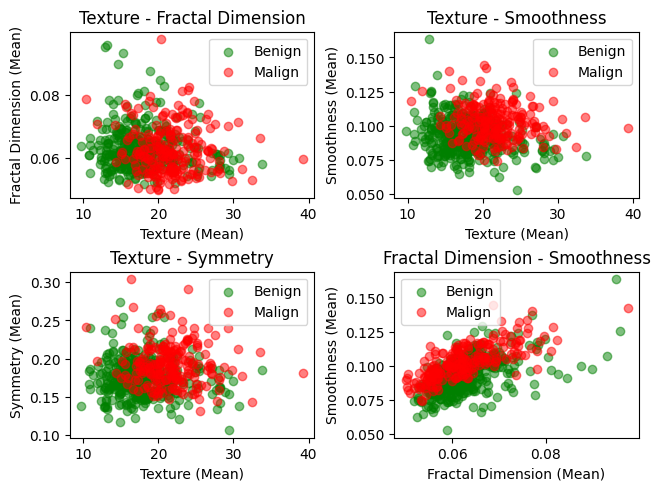

In [2]:
## Block 1: Comparison of texture features of tumor cells

# Variables
texture_features = ['texture1', 'fractal_dimension1', 'smoothness1', 'symmetry1']
fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, layout="constrained")
mask = y['Diagnosis'] == 'M'

pairs = [
    ('texture1', 'fractal_dimension1', 'Texture', 'Fractal Dimension'),
    ('texture1', 'smoothness1', 'Texture', 'Smoothness'),
    ('texture1', 'symmetry1', 'Texture', 'Symmetry'),
    ('fractal_dimension1', 'smoothness1', 'Fractal Dimension', 'Smoothness'),
]

for idx, (feat_x, feat_y, label_x, label_y) in enumerate(pairs):
    row, col = divmod(idx, 2)
    axs[row, col].scatter(X[feat_x][~mask], X[feat_y][~mask], color='green', label='Benign', alpha=0.5)
    axs[row, col].scatter(X[feat_x][mask], X[feat_y][mask], color='red', label='Malign', alpha=0.5)
    axs[row, col].set_xlabel(f'{label_x} (Mean)')
    axs[row, col].set_ylabel(f'{label_y} (Mean)')
    axs[row, col].set_title(f'{label_x} - {label_y}')
    axs[row, col].legend()
    
plt.show()

In [3]:
## Block 2: Entropy and information gain calculation for comparison of texture features of tumor cells

def entropy(data, column):
    """
    Entropy = -sum(p_i * log2(p_i))
    """
    value_counts = data[column].value_counts()
    total = len(data)

    ent = 0
    for count in value_counts:
        if count > 0:
            probability = count / total
            ent -= probability * math.log2(probability)
    return ent

def information_gain(X, y, feature, target='Diagnosis', bins=10):
    """
    Information Gain = H(target) - H(target || feature)
    """

    h_target = entropy(y, target)

    combined = pd.DataFrame({
        'feature_binned': pd.cut(X[feature], bins=bins),
        target: y[target]
    })

    h_conditional = 0
    total = len(combined)
    for bin_value, group in combined.groupby('feature_binned', observed=True):
        weight = len(group) / total
        h_conditional += weight * entropy(group, target)

    return h_target - h_conditional

print(f'Baseline Entropy of Diagnosis: {entropy(y, "Diagnosis"):.4f}\n')

for feature in texture_features:
    ig = information_gain(X, y, feature)
    print(f'Information Gain for {feature}: {ig:.4f}')

Baseline Entropy of Diagnosis: 0.9526

Information Gain for texture1: 0.1844
Information Gain for fractal_dimension1: 0.0308
Information Gain for smoothness1: 0.1137
Information Gain for symmetry1: 0.0929


Accuracy: 0.7719

              precision    recall  f1-score   support

      Benign       0.86      0.76      0.81       108
      Malign       0.66      0.79      0.72        63

    accuracy                           0.77       171
   macro avg       0.76      0.78      0.76       171
weighted avg       0.79      0.77      0.78       171



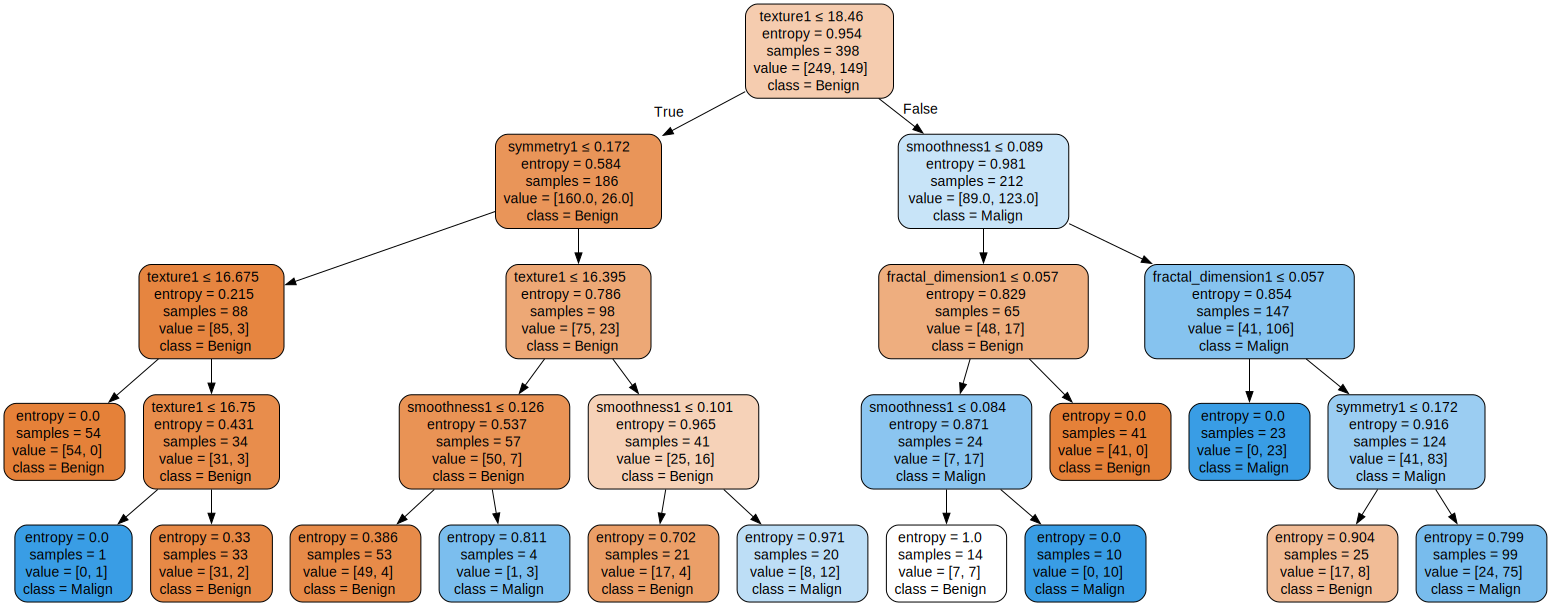

In [4]:
# Block 3: Decision Tree Classifier for texture

X_selected = X[texture_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y['Diagnosis'], test_size=0.3, random_state=42
)

clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=4)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.4f}\n')
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malign']))

dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=texture_features,
    class_names=['Benign', 'Malign'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
display(graph)